This prorgam load data, clean data, and combine Baysian stastistics with Markov chain Monte Carlo (MCMC) method to classfy 500,000 stars properties.

In [1]:
import numpy as np
from numpy import inf
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import emcee
import corner
import pickle

In [2]:
Number = 0

Load in all the astronomical properties for the galaxy

In [3]:
#half_light name, R_hl in degrees, in kpc (Munoz )
Half_light = [['Draco', 0.1612, 0.214], ['Sculptor', 0.1862, 0.280], ['Sextans', 0.2750, 0.413], ['Ursa_Minor', 0.3050, 0.407], ['Fornax', 0.3267, 0.838],['Carina', 0.1683, 0.308]]
#Tidal_radius name, R_td in degrees (Munoz )
Tidal_radius = [['Draco', 0.8017], ['Sculptor', 1.235], ['Sextans', 1.0083], ['Ursa_Minor', 1.2883], ['Fornax', 1.1517],['Carina', 0.9733]]

#[name, center ra, center dec, distance to sun in kpc,pmra,epmra,pmdec,epmdec] (distance:Munoz for Draco and UMi)
Alp_bet = [['Draco',260.052,57.915,76,-0.019,0.009,-0.145,0.010],['Sculptor',15.039,-33.709,86,0.082,0.005,-0.131,0.004],['Sextans',153.263,-1.615,86,-0.496,0.025,0.077,0.020,-0.496,0.025,0.077,0.020],["Ursa_Minor",227.285,67.223,76,-0.182,0.01,0.074,0.008],["Fornax",39.997,-34.449,147,0.376,0.003,-0.413,0.003],["Carina",100.4029,-50.9661,105,0.495,0.015,-0.143,0.014]]
Name = Alp_bet[Number][0]

#eliptical tidal radius name, R_td in degrees(a), R_e_td in degree (b), position angle in degree, Vsys
Ellip_tidal = [['Draco', 0.8017, 0.9582, 87, -291.0], ['Sculptor',1.235, 1.5088, 92, 111.4], ['Sextans',1.0083, 1.2052, 57, 224.3], ['Ursa_Minor', 1.2883, 1.9205, 50, -246.9], ['Fornax', 1.1517, 1.3668, 45, 55.2], ['Carina', 0.9733, 1.2166, 60, 222.9]]

#Mcconachie DR2: name, pmra, epmra, pmdec, epmdec
PM_MC2 =  [['Draco',-0.01,0.01,-0.14,0.01],['Sculptor',0.081, 0.005, -0.136, 0.004],['Sextans', -0.44, 0.02, 0.09, 0.02],["Ursa_Minor",-0.16, 0.01, 0.06, 0.01],["Fornax", 0.380, 0.002, -0.416, 0.004 ],["Carina", 0.48, 0.01, 0.13, 0.01]]

#Mcconachie EDR3: name, pmra, epmra, pmdec, epmdec
PM_MC3 =  [['Draco',0.042, 0.005, -0.19, 0.01],['Sculptor',0.099, 0.002, -0.160, 0.002],['Sextans', -0.41, 0.01, 0.04, 0.01],["Ursa_Minor",-0.124, 0.004, 0.078, 0.004],["Fornax", 0.382, 0.001, -0.359, 0.002 ],["Carina", 0.53, 0.01, 0.12, 0.01]]

#V_radial dispersion from Munoz18
Sigma_V = [['Draco', 9.1], ['Sculptor', 9.2], ['Sextans', 7.9], ['Ursa_Minor', 9.5], ['Fornax', 11.7],['Carina', 6.6]]



Name = Alp_bet[Number][0]

print(Name)

Draco


Load and clean data 

In [4]:
# Load star data from files
def Read_Fits(dire,L_Cir,U_Cir):
    Hdul = fits.open("Name.fits")

    Name = Alp_bet[Number][0]
    cent_R = Alp_bet[Number][1]
    cent_D = Alp_bet[Number][2]
    Dist = Alp_bet[Number][3]
    GPMRA = Alp_bet[Number][4]
    GEPMRA =Alp_bet[Number][5]
    GPMDEC = Alp_bet[Number][6]
    GEPMDEC = Alp_bet[Number][7]
    Data = Hdul[1].data

    nan_count = 0
    ra = []
    dec = []
    pmra = []
    pmdec = []
    Gbp = []    
    Grp = []    
    G_br = [] 
    G_Mag = []
    PLX = []
    PLXE = []
    Epmra = []
    Epmdec = []
    Epos = []
    Cor = []
    ID = []
    Vesc = vesc(MWPotential2014,Dist/8) * 220
    print(Vesc)
    for i in range((len(Data))):
        a = np.radians(Data['ra      '][i])
        d = np.radians(Data['dec     '][i])
        a_deg = Data['ra      '][i]
        d_deg = Data['dec     '][i]
        ea = Data['ra_error'][i]
        ed = Data['dec_error'][i]
        pa = Data['pmra    '][i]
        pd = Data['pmdec   '][i]
        epa = Data['pmra_error'][i]
        epd = Data['pmdec_error'][i]
        plx = Data['Parallax'][i]
        plx_e = Data['Parallax_error'][i]
        g = Data['phot_g_mean_mag_0'][i]
        grp = Data['G_RP_0'][i]
    
        cor = Data['pmra_pmdec_corr'][i]
        s_id = Data['source_id'][i]
        
        pos = ea**2+ed**2
        
        L_PM = (pa**2+pd**2)**(0.5) - 3* (epa**2+epd**2)**(0.5)
        
        
        if math.isnan(a) or math.isnan(d) or math.isnan(pa) or math.isnan(pd):
            pass
        #apply different qulity cuts for data
        else:
            plx_cut = plx_e/plx
            if L_PM * 4.74 * Dist <=  Vesc: 
                LL = L_Cir**2
                UL = U_Cir**2
                Ac = np.radians(cent_R)
                Dc = np.radians(cent_D)
                x = -180/np.pi*(np.cos(d)*np.sin(a-Ac))
                y = 180/np.pi*(np.sin(d)*np.cos(Dc)-np.cos(d)*np.sin(Dc)*np.cos(a-Ac))
                R_cut = x**2 + y**2
                
                if LL <= R_cut <= UL:
                    gbr = grp
                    G_Mag.append(g)
                    G_br.append(gbr)
                    ra.append(a_deg)
                    dec.append(d_deg)
                    pmra.append(pa)
                    pmdec.append(pd)
                    Epmra.append(epa)
                    Epmdec.append(epd)
                    PLX.append(plx)
                    PLXE.append(plx_e)
                    Epos.append(math.sqrt(pos))
                    Cor.append(cor)
                    ID.append(s_id)
            else:
                pass
            
    return(ra,dec,pmra,pmdec,G_br,G_Mag,PLX,PLXE,Epmra,Epmdec,Epos,Cor,ID)     #xy, xy

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

# An astronomical cut
def Limit(dire):
    if dire == "Ursa_Minor":
        X = [.3,.3,.3,-0.1,-0.3,-0.3,0.3,0.45,0.5,0.6,0.74,1.06+0.03,0.95,0.84,0.77+0.01,0.75+0.04,0.73+0.06,0.71+0.1,0.68+0.15,0.87]
        Y = [21.5+.3,21+.3,20.7+.3,20.7+.3,20.7+.3,20.1,19.3,18.8,18,17,16,16,17,18,19,19.5,20,20.5,21,21.5]
    if dire == 'Draco':
        X = [.3,.3,.3,-0.1,-0.3,-0.3,0.3,0.45,0.5,0.6,0.74,1.06+0.03,0.95,0.84,0.77+0.01,0.75+0.04,0.73+0.06,0.71+0.1,0.68+0.15,0.87]
        Y = [21.5+.3,21+.3,20.7+.3,20.7+.3,20.7+.3,20.1,19.3,18.8,18,17,16,16,17,18,19,19.5,20,20.5,21,21.5]
    if dire == 'Sculptor':
        X = [0.3, 0.3, -0.1, -0.3, -0.3, 0.25, 0.3, 0.45, 0.5, 0.6, 0.74, 1.06, 0.95, 0.84, 0.78, 0.79, 0.79, 0.8099999999999999, 0.8300000000000001]
        Y = [21, 20.7, 20.7, 20.7, 20.1, 19.7, 19.6, 19, 18, 17, 16, 16, 17, 18, 19, 19.5, 20, 20.5, 21]
    if dire =="Sextans":
        X = [0.3, 0.3, -0.1, -0.3, -0.3, -0.2, 0.3, 0.4, 0.5, 0.6, 0.74, 1.06, 0.95, 0.84, 0.78, 0.79, 0.79, 0.8099999999999999, 0.8300000000000001]
        Y = [21, 20.7, 20.7, 20.7, 20.1, 19.7, 19.2, 19, 18, 17, 16, 16, 17, 18, 19, 19.5, 20, 20.5, 21]
    if dire == "Fornax":
        X = [0.0, 0.25-0.1-0.05, 0.25-0.06-0.05-0.2, 0.3-0.04-0.05-0.1, 0.45-0.02-0.05-0.05, 0.5, \
                       0.6, 0.74, 1.06+.1, 0.95+0.1, 0.84+0.1, 0.77+0.01+0.1+0.05, 0.75+0.04+0.1+0.05+0.05, \
                       0.73+0.06+0.1+0.1+0.05, 0.71+0.1+0.1+0.1, 0.68+0.15+0.1+0.1, 0.0]
        Y = [22.22, 21.72, 21.22, 20.72, 20.22, 19.22, 18.22, 17.22, 17.22, 18.22, 19.22, 20.22, 20.72, 21.22, 21.72, 22.22, 22.22]
    if dire == "Carina":
        X = [0.3, 0.3, -0.1, -0.3, -0.3, 0.1, 0.3, 0.35, 0.5, 0.6, 0.74, 1.06, 0.95, 0.84, 0.78, 0.79, 0.79, 0.8099999999999999, 0.8300000000000001]
        Y = [21, 20.7, 20.7, 20.7, 20.1, 19.2, 19.2, 19, 18, 17, 16, 16, 17, 18, 19, 19.5, 20, 20.5, 21]

    return(X,Y)


#check if the point is within the Limited area
def Define_Area(L,D):
    ra = []
    dec = []
    pmra = []
    pmdec = []
    Epmra = []
    Epmdec = []
    G_br = []
    G_Mag = []
    plx = []
    plxe = []
    Epos = []
    Cor = []
    ID = []
    coord = zip(L[0],L[1])
    poly = Polygon(coord)
    for i in range(len(D[0])):
        pt = Point(D[4][i],D[5][i])
        if pt.within(poly): 
            ra.append(D[0][i])
            dec.append(D[1][i])
            pmra.append(D[2][i])
            pmdec.append(D[3][i])
            G_br.append(D[4][i])
            G_Mag.append(D[5][i])
            plx.append(D[6][i])
            plxe.append(D[7][i])
            Epmra.append(D[8][i])
            Epmdec.append(D[9][i])
            Epos.append(D[10][i])
            Cor.append(D[11][i])
            ID.append(D[12][i])
    
    return(ra,dec,pmra,pmdec,G_br,G_Mag,plx,plxe,Epmra,Epmdec,Epos,Cor,ID)
    




In [5]:
#get all star data from shell_1 to shell 2
def Get_Gaia_Shell(Number,Shell_1,Shell_2):
    uo = 10
    vo = 5.25
    wo = 7.17
    
    Name = Alp_bet[Number][0]
    cent_R = Alp_bet[Number][1]
    cent_D = Alp_bet[Number][2]
    GPMRA = Alp_bet[Number][4]
    GEPMRA =Alp_bet[Number][5]
    GPMDEC = Alp_bet[Number][6]
    GEPMDEC = Alp_bet[Number][7]
    
    RD = Read_Fits(Name,Shell_1,Shell_2)
    print('number of stars before CMD cut, but after radius and parallax cuts')
    print(len(RD[0]))
    L = Limit(Name) 
    D = Define_Area(L,RD)
    print('number of stars after CMD cut')
    print(len(D[0]))
    Ra = D[0]
    Dec = D[1]
    pmRa = D[2]
    pmDec = D[3] 
    G_br = D[4]
    G_Mag = D[5]
    EpmRa = D[8]
    EpmDec = D[9]
    Cor = D[11]
    ID = D[12]
    
    return(Ra,Dec,pmRa,pmDec,EpmRa,EpmDec,Cor,G_br,G_Mag,ID)
   
#get all star data from shell_1 to shell 2 without passing the CMD cut
def Get_Gaia_Shell_noCMD(Number,Shell_1,Shell_2):
    uo = 10
    vo = 5.25
    wo = 7.17
    
    Name = Alp_bet[Number][0]
    cent_R = Alp_bet[Number][1]
    cent_D = Alp_bet[Number][2]
    GPMRA = Alp_bet[Number][4]
    GEPMRA =Alp_bet[Number][5]
    GPMDEC = Alp_bet[Number][6]
    GEPMDEC = Alp_bet[Number][7]
    
    
    NMemb = [['Draco',422],['Sculptor',1592],['Sextans',205],["Ursa_Minor",925],["Fornax",7722]]
    Memb = NMemb[Number][1]
    

    RD = Read_Fits(Name,Shell_1,Shell_2)
    
    Ra = RD[0]
    Dec = RD[1]
    pmRa = RD[2]
    pmDec = RD[3] 
    G_br = RD[4]
    G_Mag = RD[5]
    EpmRa = RD[8]
    EpmDec = RD[9]
    Cor = RD[11]
    
    return(Ra,Dec,pmRa,pmDec,EpmRa,EpmDec,Cor,G_br,G_Mag)
   


In [6]:
Gaia_CMD_3 = Get_Gaia_Shell(Number,0,3)

307.7401363219586
number of stars before CMD cut, but after radius and parallax cuts
15704
number of stars after CMD cut
10799


In [7]:
Tuple_CMD_3 = list(zip(Gaia_CMD_3[0], Gaia_CMD_3[1], Gaia_CMD_3[2],Gaia_CMD_3[3], Gaia_CMD_3[4], Gaia_CMD_3[5], Gaia_CMD_3[6], Gaia_CMD_3[7], Gaia_CMD_3[8], Gaia_CMD_3[9]))


dtype = [('ra',float), ('dec',float), ('pmra',float), ('pmdec',float), ('pmra_error',float),
            ('pmdec_error',float), ('pmra_pmdec_corr',float), ('g_br',float), ('g',float), ('id',float)]


Array_CMD_3 = np.array(Tuple_CMD_3, dtype=dtype)


Visualize the distribution of data 

Text(0.5, 0.98, 'Draco EDR3 0-3 deg')

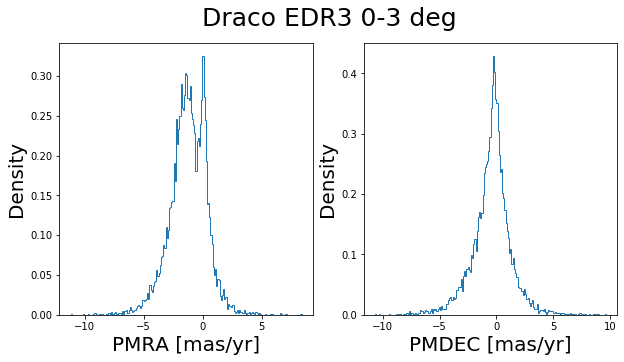

In [14]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
ax1.hist(Gaia_CMD_3[2],200,histtype = 'step',density = True)
ax1.set_xlabel('PMRA [mas/yr]',fontsize=20)
ax1.set_ylabel('Density',fontsize=20)

ax2.hist(Gaia_CMD_3[3],200,histtype = 'step',density = True)
ax2.set_xlabel('PMDEC [mas/yr]',fontsize=20)
ax2.set_ylabel('Density',fontsize=20)
fig.suptitle('Draco EDR3 0-3 deg' ,fontsize=25)

Baysian statistics models

In [9]:
#PM dispersion converted from sigma V_radial
Dist = Alp_bet[Number][3]
disp = Sigma_V[Number][1]/(4.74 * Dist)

# add coveriance 
def calc_cov_wcs(data, disp=disp):

    cov = np.zeros((len(data), 2, 2))
    cov[:,0,0] = data['pmra_error']**2 + disp**2
    cov[:,0,1] = data['pmra_error'] * data['pmdec_error'] * data['pmra_pmdec_corr']
    cov[:,1,0] = data['pmra_error'] * data['pmdec_error'] * data['pmra_pmdec_corr']
    cov[:,1,1] = data['pmdec_error']**2 + disp**2
    
    cov2 = np.zeros((len(data), 2, 2))
    cov2[:,0,0] = data['pmra_error']**2
    cov2[:,0,1] = data['pmra_error'] * data['pmdec_error'] * data['pmra_pmdec_corr']
    cov2[:,1,0] = data['pmra_error'] * data['pmdec_error'] * data['pmra_pmdec_corr']
    cov2[:,1,1] = data['pmdec_error']**2 
        
    return cov, cov2

# maximum log likelihood model with spatial parameters
def spat_model(cx, cy, Rmax, ah):
    
    radius = np.sqrt(cx**2 + cy**2)
    
    model1 = 2.*ah**2.*radius*(ah**2.+Rmax**2.)/(Rmax**2.*(ah**2.+radius**2.)**2.)
    model2 = 2.*np.pi*radius/(np.pi*Rmax**2.)
    
    return model1, model2


#Version of the spatial model that includes the ellipticity as a free parameter
def spat_model_ellip(cx, cy, Rmax, ah, pa, ellip):
    
    rx = cx*np.cos(np.deg2rad(pa)) - cy*np.sin(np.deg2rad(pa))
    ry = cx*np.sin(np.deg2rad(pa)) + cy*np.cos(np.deg2rad(pa))
    
    radius = np.sqrt(rx**2. + (ry**2./(1. - ellip)**2.))
    
    #model1 = 2.*ah**2.*radius*np.sqrt((Rmax**2. + ah**2.)*(Rmax**2. + (1. - ellip)**2.*ah**2.)) / \
    #((1 - ellip) * Rmax**2. * (ah**2. + radius**2.)**2.)
    #model2 = 2.*np.pi*radius/(np.pi*Rmax**2.)
    
    model1 = ah**2.*np.sqrt((Rmax**2. + ah**2.)*(Rmax**2. + (1. - ellip)**2.*ah**2.)) / \
    ((1 - ellip) * Rmax**2. * (ah**2. + radius**2.)**2.)
    model2 = np.pi/(np.pi*Rmax**2.)
    
    return model1, model2


In [10]:
#Translate the mean proper motions into velocities

def pm2vel(mue, mun, dist):
    
    # Total center of mass (CM) proper motion
    mutran = (mue**2 + mun**2)**(0.5)
    
    # angle of motion for the CM PM and convert from traditional definition of on-sky angles
    thtran = np.deg2rad(np.rad2deg(np.arctan2(mue, mun)) + 90.0)
    
    # total CM velocity
    vtran = 4.7403885 * mutran * dist
    
    return thtran, vtran

# Convert to Gaia cartesian coordinates
def wcs2gaiaxy(ra, dec, center):
    x = np.cos(dec) * np.sin(ra-center[0])
    y = np.sin(dec) * np.cos(center[1]) - np.cos(dec) * np.sin(center[1]) * np.cos(ra - center[0])

    x = np.rad2deg(x)
    y = np.rad2deg(y)

    return x,y

# Function to convert X/Y coordinates (that were transformed from RA/Dec) to angular coordinates

def wcsxy2ang(x, y, dist0):
    
    rho = np.arctan2( ((x**2 + y**2)**(0.5)), (dist0**(0.5)))
    phi = np.arctan2(y, x)

    return rho, phi


# Function to convert from WCS to angular coordinates

def wcs2ang(ra0, dec0, ra, dec):

    rho = np.arccos( np.cos(dec) * np.cos(dec0) * np.cos(ra - ra0) + np.sin(dec) * np.sin(dec0) )

    phi = np.arccos( (-1.0*np.cos(dec) * np.sin(ra - ra0)) / (np.sin(rho)) )

# Calculate Cartesian coordinates to test for correcting the angle

    testx, testy = wcs2gaiaxy(ra, dec, np.asarray([ra0, dec0]))

    for i in range(len(testy)):
        if (testy[i] < 0.0):
            phi[i] = -1.0*phi[i]

    return rho, phi


# Function to create vectors (v1, v2, v3) for the center of 
# mass motion

def make_cm_angvec(vtran, thtran, vsys, rho, phi):

    v1 = vtran*np.sin(rho)*np.cos(phi - thtran) + vsys*np.cos(rho)
    v2 = vtran*np.cos(rho)*np.cos(phi - thtran) - vsys*np.sin(rho)
    v3 = -1.0 * vtran * np.sin(phi - thtran)

    return v1, v2, v3

# Function to calculate the Gamma factor for vector transformations

def calc_gamma(ra0, dec0, ra, dec, rho):

    cosG = (np.sin(dec) * np.cos(dec0) * np.cos(ra-ra0) - np.cos(dec)*np.sin(dec0)) / np.sin(rho)

    sinG = (np.cos(dec0) * np.sin(ra - ra0)) / np.sin(rho)

    return cosG, sinG

# Function to convert an angular vector to wcs

def ang2wcs_vec(dist0, v2, v3, cosG, sinG, rho, phi, theta=np.deg2rad(0.00001), inclin=np.deg2rad(0.00001)):

# Calculates the scaling quantity for the proper motion

    propercon = (np.cos(inclin) * np.cos(rho) - np.sin(inclin)*np.sin(rho)*np.sin(phi-theta)) \
    / (dist0 * np.cos(inclin))

# Use the scaling quantity and the vector components in the skyplane
# to calculate the observable proper motions 

    muwe = (propercon * (-1.0*sinG*(v2) - cosG*(v3))) / (4.7403895)
    muno = (propercon * (cosG*(v2) - sinG*(v3))) / (4.7403895)

    return muwe, muno

# Function to calculate the transverse velocity and angle from given
# mu_E (mas/yr), mu_N (mas/yr), and distance (kpc)

def calc_transverse(mu_E, mu_N, dist0):

  
    # total CM proper motion
    mu_tran = (mu_E**2 + mu_N**2)**(0.5)
  
    # angle of motion for the CM PM (uses the standard north over east
    # assumption then shifts the angle to refer to quadrant 1)
    thtran = np.deg2rad(np.rad2deg(np.arctan2(mu_E, mu_N)) + 90.0)

    # total CM velocity
    vtran = 4.7403885 * mu_tran * dist0

    return vtran, thtran

################################################################

################################################################
#### Function to calculate the viewing perspective correction
#### for a given system and set of points
#
## Required inputs:
# vtran: the transverse velocity total
# thtran: angle of the transverse vector
# vsys: systemic radial velocity
# dist0: distance to the center of the galaxy
# ra0: RA center of the galaxy
# dec0: Dec center of the galaxy
# ra: column from an array containing the RA coordinates of the points to calculate the CM vector
# dec: column from an array containing the Dec coordinates of the points to calculate the CM vector
# incl: inclination angle of the galaxy to the plane of the sky
# theta: angle of intersection between the galaxy and viewing plane
#
## Outputs:
#

def viewing_cor(muE0, muN0, vsys, dist0, ra0, dec0, ra, dec, inclin=0.0000001, theta=0.0000001):

# Calculate the transverse velocity and angle of the CoM
    vtran, thtran = calc_transverse(muE0, muN0, dist0)

    #print(vtran, np.rad2deg(thtran))
    
# Calculate observational coordinates of the input columns
    rho, phi = wcs2ang(ra0, dec0, ra, dec)

# Calculate the vector components of the CoM motion using given coordinates and parameters
    v1, v2, v3 = make_cm_angvec(vtran, thtran, vsys, rho, phi)


# Calculate the gamma factor for the proper motion calculation
    cosG, sinG = calc_gamma(ra0, dec0, ra, dec, rho)

# Calculate the proper motion for each coordinate
    muw, mun = ang2wcs_vec(dist0, v2, v3, cosG, sinG, rho, phi, theta=theta, inclin=inclin)

# Flip the mu_west PMs to mu_east orientation
    mue = -1.0 * muw

# Subtract the CoM PM from the calculated coordinate PMs to get the residuals
    muecor = mue - muE0
    muncor = mun - muN0

    rvcor = v1 - vsys

    return muecor, muncor, rvcor

##########################################################################

################################################################
#### Function to apply the viewing correction and return new proper motions to be used

def apply_cor(mu_ra1, mu_dec1, dist, vsys, center, data, cx, cy):
    
    # Calculate the direction and scale of the total proper motion vector assumed
    thtran, vtran = pm2vel(mu_ra1, mu_dec1, dist)
        
    # Calculate the viewing perspective correction, assuming a systemic motion of mu_ra1, mu_dec1
    pmracor, pmdeccor, rvcor = viewing_cor(mu_ra1, mu_dec1, vsys, dist, center[0], center[1], \
                                    np.deg2rad(data['ra']), np.deg2rad(data['dec']))
        
    # Remove the corrected systemic motion then re-center the proper motions around the systemic motion
    newpmra = np.copy(data['pmra']) - pmracor
    newpmdec = np.copy(data['pmdec']) - pmdeccor
    
    return newpmra, newpmdec

################################################################

In [11]:
def pm_gauss_model_wcs(pmra, pmdec, cov, mu_ra, mu_dec):

    diff = np.zeros((len(pmra), 2, 1))
    
    diff[:,0,0] = pmra - mu_ra
    diff[:,1,0] = pmdec - mu_dec
    
    model = np.zeros((len(pmra)))
    
    covdet = cov[:,0,0]*cov[:,1,1] - cov[:,0,1]*cov[:,1,0]
    
    invcov = np.zeros((len(cov), 2, 2))
    
    invcov[:,0,0] = cov[:,0,0] / covdet
    invcov[:,0,1] = cov[:,0,1] / covdet
    invcov[:,1,0] = cov[:,1,0] / covdet
    invcov[:,1,1] = cov[:,1,1] / covdet
    
    model = covdet**(-0.5) * np.exp(-0.5*(diff[:,0,0]*(invcov[:,1,1]*diff[:,0,0]-invcov[:,0,1]*diff[:,1,0]) + \
                                          diff[:,1,0]*(-1.0*invcov[:,1,0]*diff[:,0,0]+invcov[:,0,0]*diff[:,1,0])))
    
    return model



#Total log likelihood function
def total_ln_like(theta, data, cov, cov2, perm, usecor, Rmax, dist, center, cx, cy, vsys):
    
    #data, cov, cov2, mu_x1, mu_y1, mu_x2, mu_y2, sigma_x2, sigma_y2 - PM
    # data, Rmax, ah, pa, ellip- spatial
    
    cov_2 = np.copy(cov2) #this line is so that the original covariance matrix doesn't get overwritten
    
    
## permutation for only the proper motion for likelihood
    if (perm == 'PM_only'):
        frac, mu_ra1, mu_dec1, mu_ra2, mu_dec2, sigma_ra2, sigma_dec2 = theta
        cov_2[:,0,0] += sigma_ra2**2
        cov_2[:,1,1] += sigma_dec2**2
        
        if (usecor):
            newpmra, newpmdec = apply_cor(mu_ra1, mu_dec1, dist, vsys, center, data, cx, cy)
        else:
            newpmra, newpmdec = data['pmra'], data['pmdec']
            
        # Calculate the PM likelihoods for each population
        pmmodel1 = pm_gauss_model_wcs(newpmra, newpmdec, cov, mu_ra1, mu_dec1)
        pmmodel2 = pm_gauss_model_wcs(newpmra, newpmdec, cov_2, mu_ra2, mu_dec2)
        
        like = np.sum(np.log(frac * pmmodel1 + (1.0 - frac) * pmmodel2))
        
        
## permutation for only the spherical spatial case
    elif (perm=='sph_spat_only'):
        frac, ah = theta
        spatmodel1, spatmodel2 = spat_model(cx, cy, Rmax, ah)
        like = np.sum(np.log(frac * spatmodel1 + (1.0 - frac) * spatmodel2))
        
        
## permutation for the elliptical spatial case plus proper motion for likelihood
    elif (perm=='ellip_spat_only'):
        frac, ah, pa, ellip = theta
        spatmodel1, spatmodel2 = spat_model_ellip(cx, cy, Rmax, ah, pa, ellip)
        like = np.sum(np.log(frac * spatmodel1 + (1.0 - frac) * spatmodel2))
         
            
## permutation for the spherical spatial case plus proper motion for likelihood
    elif (perm=='PM_sph_spat'):
        frac, mu_x1, mu_y1, mu_x2, mu_y2, sigma_x2, sigma_y2, ah = theta
        cov_2[:,0,0] += sigma_x2**2
        cov_2[:,1,1] += sigma_y2**2

        if (usecor):
            newpmra, newpmdec = apply_cor(mu_ra1, mu_dec1, dist, vsys, center, data, cx, cy)
        else:
            newpmra, newpmdec = data['pmra'], data['pmdec']        

        # Calculate the PM likelihoods for each population
        pmmodel1 = pm_gauss_model_wcs(newpmra, newpmdec, cov, mu_ra1, mu_dec1)
        pmmodel2 = pm_gauss_model_wcs(newpmra, newpmdec, cov_2, mu_ra2, mu_dec2)
        
        spatmodel1, spatmodel2 = spat_model(cx, cy, Rmax, ah)
        like = np.sum(np.log(frac * pmmodel1 * spatmodel1 + (1.0 - frac) * pmmodel2 * spatmodel2))
        
## permutation for the elliptical spatial case plus proper motion for likelihood
    elif (perm=='PM_ellip_spat'):
        frac, mu_ra1, mu_dec1, mu_ra2, mu_dec2, log_sigma_ra2, log_sigma_dec2, log_ah, pa, ellip = theta
        cov_2[:,0,0] += (10**log_sigma_ra2)**2
        cov_2[:,1,1] += (10**log_sigma_dec2)**2
        
        if (usecor):
            newpmra, newpmdec = apply_cor(mu_ra1, mu_dec1, dist, vsys, center, data, cx, cy)
        else:
            newpmra, newpmdec = data['pmra'], data['pmdec']  
        
        # Calculate the PM likelihoods for each population
        pmmodel1 = pm_gauss_model_wcs(newpmra, newpmdec, cov, mu_ra1, mu_dec1)
        pmmodel2 = pm_gauss_model_wcs(newpmra, newpmdec, cov_2, mu_ra2, mu_dec2)
        
        # Calculate the spatial likelihoods for each population
        spatmodel1, spatmodel2 = spat_model_ellip(cx, cy, Rmax, 10**log_ah, pa, ellip)
        
        # Combine with the fraction, take the log, then sum over all data points
        like = np.sum(np.log(frac * pmmodel1 * spatmodel1 + (1.0 - frac) * pmmodel2 * spatmodel2))
        
    
    return like


# function to check that all priors are within flat prior range. For now it's set up assuming flat priors. Will
# examine how to modify the setup to include the ability to assign Gaussian priors.

def ln_prior(theta, perm):
    if (perm == 'PM_only'):
        frac, mu_ra1, mu_dec1, mu_ra2, mu_dec2, sigma_ra2, sigma_dec2 = theta
        
        lp = 0. if (0 < frac < 1) and (0.01 <= sigma_ra2 <= 10) and (0.01 <= sigma_dec2 <= 10) \
        and (-1 < mu_ra1 < 1) and (-1 < mu_dec1 < 1) and (-5 < mu_ra2 < 5) and (-5 < mu_dec2 < 5) else -np.inf
        
        
    elif (perm == 'PM_wcs_only'):
        frac, mu_ra1, mu_dec1, mu_ra2, mu_dec2, sigma_ra2, sigma_dec2 = theta
        
        lp = 0. if (0 < frac < 1) and (0.01 <= sigma_ra2 <= 10) and (0.01 <= sigma_dec2 <= 10) \
        and (-1 < mu_ra1 < 1) and (-1 < mu_dec1 < 1) and (-5 < mu_ra2 < 5) and (-5 < mu_dec2 < 5) else -np.inf
        
        
    elif (perm == 'sph_spat_only'):
        frac, ah = theta
        
        lp = 0. if (0 < frac < 1) and (0.01 <= ah < 1) else -np.inf
        
    elif (perm=='ellip_spat_only'):
        frac, ah, pa, ellip = theta
        
        lp = 0. if (0 < frac < 1) and (0.01 <= ah < 1) and (-90.0 < pa < 90.) and (0. <= ellip < 0.8) else -np.inf
        
        
    elif (perm=='PM_sph_spat'):
        frac, mu_ra1, mu_dec1, mu_ra2, mu_dec2, sigma_ra2, sigma_dec2, ah = theta
        
        lp = 0. if (0<frac<1) and (0.01 <= ah < 1) and (0.01 <= sigma_ra2 <= 10) and (0.01 <= sigma_dec2 <= 10) \
        and (-1 < mu_ra1 < 1) and (-1 < mu_dec1 < 1) and (-5 < mu_ra2 < 5) and (-5 < mu_dec2 < 5) else -np.inf
        
    elif (perm=='PM_ellip_spat'):
        frac, mu_ra1, mu_dec1, mu_ra2, mu_dec2, log_sigma_ra2, log_sigma_dec2, log_ah, pa, ellip = theta
        
        lp = 0. if (0 < frac < 1) and (-2 <= log_ah < 0) and (-2 <= log_sigma_ra2 <= 1) and \
        (-2 <= log_sigma_dec2 <= 1) and (-1 < mu_ra1 < 1) and (-1 < mu_dec1 < 1) and (-5 < mu_ra2 < 5) and \
        (-5 < mu_dec2 < 5) and (-90. < pa < 90.) and (0. <= ellip < 1.0) else -np.inf
        
    else:
        lp = -np.inf

        
    return lp
        
#def total_ln_like(theta, data, perm='PM_ellip_spat', cov=None, cov2=None, Rmax=None): guesses
def ln_prob(theta, data, cov, cov2, perm, usecor, Rmax, dist, center, cx, cy, vsys):
        
    lp = ln_prior(theta, perm)
    if not np.isfinite(lp):
        return -np.inf
    try:
        lnprobval = lp + total_ln_like(theta, data, cov, cov2, perm, usecor, Rmax, dist, center, cx, cy, vsys)
    except ValueError: # NaN value case
        lnprobval = -np.inf
        
    return lnprobval

In [18]:
# create initial priors for MCMC
def create_initial(p0, priors):
    
    for a in range(len(p0[0])):
        p0[:,a] = (p0[:,a] * (priors[a][1] - priors[a][0])) + priors[a][[0]]
        
    return p0

# Limit the priors distribution for MCMC
def get_priors(perm):
    
    if perm == 'sph_spat_only':
        nparams = 2
        params = ['frac', 'ah']
        priors = np.asarray([[0., 1.], [0.1, 1.]])
        
    elif perm == 'ellip_spat_only':
        nparams = 4
        params = ['frac', 'ah', 'pa', 'ellip']
        priors = np.asarray([[0., 1.], [0.1, 1.], [-90.0, 90.0], [0., 0.8]])
        
    elif perm == 'PM_only':
        nparams = 7
        params = ['frac','mu_ra1','mu_dec1','mu_ra2','mu_dec2','sigma_ra2','sigma_dec2']
        priors = np.asarray([[0., 1.], [-1., 1.], [-1., 1.], [-5., 5.], [-5., 5.], [0.01, 10.], [0.01, 10.]])
        
    elif perm == 'PM_sph_spat':
        nparams = 8
        params = ['frac','mu_ra1','mu_dec1','mu_ra2','mu_dec2','sigma_ra2', 'sigma_dec2','ah']
        priors = np.asarray([[0., 1.], [-1., 1.], [-1., 1.], [-5., 5.], [-5., 5.], [-5., 5.], \
                             [-5., 5.], [0.1, 1.]])
           
    elif perm == 'PM_ellip_spat':
        nparams = 10
        params = ['frac','mu_ra1','mu_dec1','mu_ra2','mu_dec2', 'log_sigma_ra2','log_sigma_dec2','log_ah','pa','ellip']
        priors = np.asarray([[0., 1.], [-1., 1.], [-1., 1.], [-5., 5.], [-5., 5.], [-2, 1], [-2, 1.], \
                  [-2, 0], [-90.0, 90.0], [0., 1.0]])
        
    return priors, nparams, params


def run_MCMC(data, nparams, perm, usecor, Rmax, center, dist, cx, cy, vsys):
    
    # Calculate the covariance matrices
    cov, cov2 = calc_cov_wcs(data)

    # Set the number of dimensions and number of walkers desired
    ndim, nwalkers = nparams, 400 #300
    
    # Create the initial state used to sample the space
    p0 = np.random.rand(nwalkers, ndim)
    
    p0 = create_initial(p0, priors)
    
    # Create the sampler itself
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, args=[data, cov, cov2, perm, usecor, Rmax, \
                                                                   dist, center, cx, cy, vsys])
    
    print("Running burn-in...")
    state = sampler.run_mcmc(p0, 600, progress=True)
    sampler.reset()
    sampler.run_mcmc(state, 600, progress=True);
    
    #samples = sampler.get_chain(flat=True)
    samples = sampler.get_chain(flat=True, discard=300)
    
        
    return samples, cov, cov2




Run MCMC, show coner plots with prior distribution based on Baysisan statistics.

10 11931
Running burn-in...
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in log



100%|██████████| 600/600 [49:15<00:00,  4.93s/it]


(120000, 10)


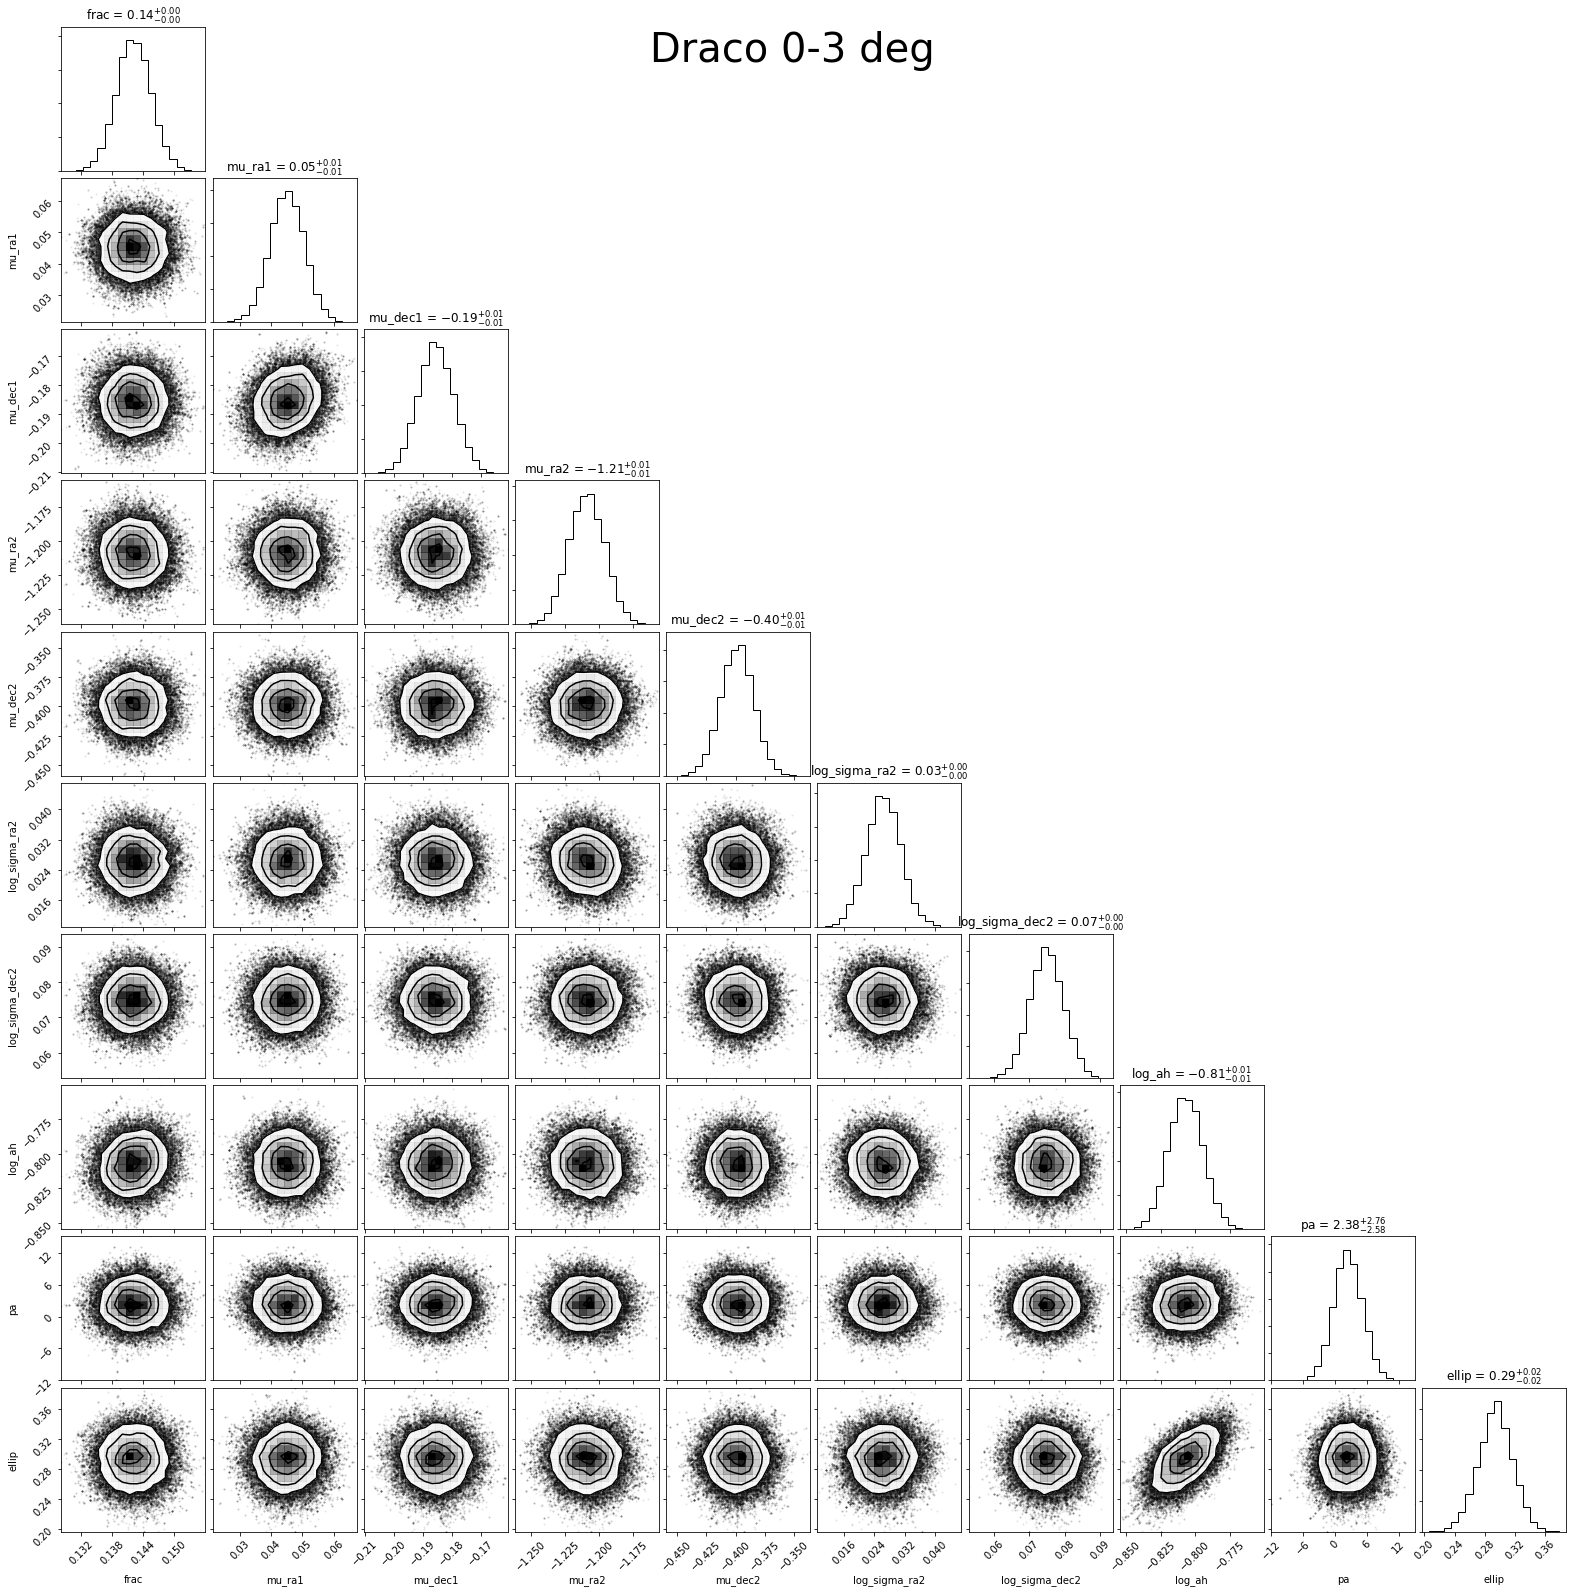

In [19]:
data = Array_CMD_3


options = ['sph_spat_only', 'ellip_spat_only', 'PM_only', 'PM_sph_spat', 'PM_ellip_spat']

option = 4
perm = options[option]

priors, nparams, params = get_priors(perm)



usecor = True #flag for whether to apply the viewing correction
Rmax = 3
cenra, cendec = Alp_bet[Number][1], Alp_bet[Number][2]
dist = Alp_bet[Number][3]
vsys = Ellip_tidal[Number][4] #Munoz18

center = np.asarray([np.deg2rad(cenra), np.deg2rad(cendec)])

#### Calculate cartesian X/Y coordinates for each star to be used in the MCMC
cartx, carty = wcs2gaiaxy(np.deg2rad(data['ra']), np.deg2rad(data['dec']), center)

#### Trim data, using the new X/Y coordinates to be limited by Rmax
newdata = data[(np.sqrt(cartx**2 + carty**2) <= Rmax)]

cx, cy = wcs2gaiaxy(np.deg2rad(newdata['ra']), np.deg2rad(newdata['dec']), center)

print(nparams, len(newdata))

mcmc_Results, cov, cov2 = run_MCMC(newdata, nparams, perm=perm, usecor=usecor, Rmax=Rmax, center=center, \
                                   dist=dist, cx=cx, cy=cy, vsys=vsys)

print(mcmc_Results.shape)

#fig = corner.corner(mcmc_Results,labels=guesses['param'],quantiles=[0.16, 0.5, 0.84],\
#                    show_titles=True, title_kwargs={"fontsize": 12},figsize = (7, 7))

fig = corner.corner(mcmc_Results,labels=params,show_titles=True, title_kwargs={"fontsize": 12},\
                    figsize = (7, 7))
fig.suptitle(Name+" 0-3 deg",fontsize = 40);

calculate probability of a certain star is a member of this galaxy

In [20]:
def posteriors(data, cov, cov_2, results, perm, usecor=True):
    
    if (perm=='PM_only'):
        frac = np.median(results[:,0])
        mu_ra1 = np.median(results[:,1])
        mu_dec1 = np.median(results[:,2])
        mu_ra2 = np.median(results[:,3])
        mu_dec2 = np.median(results[:,4])
        sigma_ra2 = 10**np.median(results[:,5])
        sigma_dec2 = 10**np.median(results[:,6])
        
        cov_2[:,0,0] += sigma_ra2**2
        cov_2[:,1,1] += sigma_dec2**2
        
        if (usecor):
            newpmra, newpmdec = apply_cor(mu_ra1, mu_dec1, dist, vsys, center, data, cx, cy)
        else:
            newpmra, newpmdec = data['pmra'], data['pmdec']
            
        # Calculate the PM likelihoods for each population
        pmmodel1 = pm_gauss_model_wcs(newpmra, newpmdec, cov, mu_ra1, mu_dec1)
        pmmodel2 = pm_gauss_model_wcs(newpmra, newpmdec, cov_2, mu_ra2, mu_dec2)
        
        like = np.sum(np.log(frac * pmmodel1 + (1.0 - frac) * pmmodel2))
        
        Tot = frac * pmmodel1  + (1.0 - frac) * pmmodel2 
        model1 = frac * pmmodel1 
        P = model1/Tot
        
        return P
    
    if (perm=='PM_ellip_spat'):
        
        frac = np.median(results[:,0])
        mu_ra1 = np.median(results[:,1])
        mu_dec1 = np.median(results[:,2])
        mu_ra2 = np.median(results[:,3])
        mu_dec2 = np.median(results[:,4])
        sigma_ra2 = 10**np.median(results[:,5])
        sigma_dec2 = 10**np.median(results[:,6])
        ah = 10**np.median(results[:,7])
        pa = np.median(results[:,8])
        ellip = np.median(results[:,9])
        
        print(sigma_ra2,sigma_dec2,ah)
        cov_2[:,0,0] += sigma_ra2**2
        cov_2[:,1,1] += sigma_dec2**2
        
        if (usecor):
            newpmra, newpmdec = apply_cor(mu_ra1, mu_dec1, dist, vsys, center, data, cx, cy)
        else:
            newpmra, newpmdec = data['pmra'], data['pmdec']
            
        # Calculate the PM likelihoods for each population
        pmmodel1 = pm_gauss_model_wcs(newpmra, newpmdec, cov, mu_ra1, mu_dec1)
        pmmodel2 = pm_gauss_model_wcs(newpmra, newpmdec, cov_2, mu_ra2, mu_dec2)
        
        spatmodel1, spatmodel2 = spat_model_ellip(cx, cy, Rmax, ah, pa, ellip)
        
        # Combine with the fraction, take the log, then sum over all data points
        like = np.sum(np.log(frac * pmmodel1 * spatmodel1 + (1.0 - frac) * pmmodel2 * spatmodel2))
        
        Tot = frac * pmmodel1 * spatmodel1 + (1.0 - frac) * pmmodel2 * spatmodel2
        model1 = frac * pmmodel1 * spatmodel1
        P = model1/Tot
        return P
        
        
P_Prob = posteriors(newdata, cov, cov2, mcmc_Results, perm='PM_ellip_spat', usecor=True)
P_Prob_noSpc = posteriors(newdata, cov, cov2, mcmc_Results, perm='PM_only', usecor=True)
        

1.0624642556900241 1.1882423675678158 0.15594372361200765


Store all values

In [21]:
Gaia_data_03 = []

Gaia_data_03.append(newdata['ra'])
Gaia_data_03.append(newdata['dec'])
Gaia_data_03.append(newdata['pmra'])
Gaia_data_03.append(newdata['pmdec'])
Gaia_data_03.append(newdata['pmra_error'])
Gaia_data_03.append(newdata['pmdec_error'])
Gaia_data_03.append(newdata['pmra_pmdec_corr'])
Gaia_data_03.append(newdata['g_br'])
Gaia_data_03.append(newdata['g'])
Gaia_data_03.append(Gaia_CMD_3[9])

Final_Data = []
Final_Data.append(Gaia_data_03)
Final_Data.append(mcmc_Results)
Final_Data.append(P_Prob)
Final_Data.append(P_Prob_noSpc)

with open(Name+'No_Vari_Cut.txt', 'wb') as fp:
    pickle.dump(Final_Data, fp)


